# Model Analysis

This notebook analyzes the performance of a model based on prediction outputs with probabilities from `predictions_with_probabilities.csv`.

We will evaluate the model using standard multi-label classification metrics and calculate AUC (Area Under the ROC Curve) for each class.

In [ ]:
# Install dependencies if not already installed
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, classification_report, roc_auc_score, precision_recall_curve, average_precision_score
import ast

# Set plot style
sns.set(style="whitegrid")

# Class label mapping
class_labels = {
    0: 'greedy',
    1: 'math',
    2: 'implementation',
    3: 'dp',
    4: 'data structures',
    5: 'brute force',
    6: 'constructive algorithms',
    7: 'binary search',
    8: 'sortings',
    9: 'graphs'
}

# Class display ordering
class_order = [0, 1, 2, 3, 6, 4, 5, 7, 8, 9]

## 1. Load Data

In [3]:
file_path = 'predictions_with_probabilities_NB.csv'

df = pd.read_csv(file_path)

print(f"Data Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Data Shape: (1389, 23)

Columns: ['problem_statement', 'problem_tags', 'prob_class_0', 'prob_class_1', 'prob_class_2', 'prob_class_3', 'prob_class_4', 'prob_class_5', 'prob_class_6', 'prob_class_7', 'prob_class_8', 'prob_class_9', 'actual_class_0', 'actual_class_1', 'actual_class_2', 'actual_class_3', 'actual_class_4', 'actual_class_5', 'actual_class_6', 'actual_class_7', 'actual_class_8', 'actual_class_9', 'actual_classes']


## 2. Preprocessing

We identify the probability, prediction, and actual columns. The file contains:
- `prob_class_0` to `prob_class_9`: probability scores for each class
- `actual_class_0` to `actual_class_9`: binary labels (0 or 1) for each class

We'll convert probabilities to binary predictions using a threshold of 0.5.

In [4]:
prob_cols = [f'prob_class_{i}' for i in range(10)]
actual_cols = [f'actual_class_{i}' for i in range(10)]

# Verify columns exist
assert all(col in df.columns for col in prob_cols + actual_cols), f"Missing columns. Available: {df.columns.tolist()}"

# Convert probabilities to binary predictions using threshold 0.5
pred_cols = [f'predicted_class_{i}' for i in range(10)]
for i in range(10):
    df[pred_cols[i]] = (df[prob_cols[i]] >= 0.5).astype(int)

print(f"Converted probabilities to binary predictions using threshold 0.5")
print(f"Probability columns: {prob_cols[:3]}...")
print(f"Actual columns: {actual_cols[:3]}...")
print(f"Prediction columns: {pred_cols[:3]}...")

Converted probabilities to binary predictions using threshold 0.5
Probability columns: ['prob_class_0', 'prob_class_1', 'prob_class_2']...
Actual columns: ['actual_class_0', 'actual_class_1', 'actual_class_2']...
Prediction columns: ['predicted_class_0', 'predicted_class_1', 'predicted_class_2']...


## 3. Evaluation Metrics

We define a function to calculate key metrics for multi-label classification:
- **Accuracy (Subset Accuracy)**: The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
- **Hamming Loss**: The fraction of labels that are incorrectly predicted.
- **Precision, Recall, F1 (Micro/Macro)**: Aggregated metrics.
- **AUC (Area Under the ROC Curve)**: Calculated for each class using probability scores.

In [5]:
def evaluate_model(df, name="Model"):
    y_true = df[actual_cols].values
    y_pred = df[pred_cols].values
    y_probs = df[prob_cols].values
    
    metrics = {}
    metrics['Model'] = name
    metrics['Subset Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Hamming Loss'] = hamming_loss(y_true, y_pred)
    metrics['Micro Precision'] = precision_score(y_true, y_pred, average='micro')
    metrics['Micro Recall'] = recall_score(y_true, y_pred, average='micro')
    metrics['Micro F1'] = f1_score(y_true, y_pred, average='micro')
    metrics['Macro Precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['Macro Recall'] = recall_score(y_true, y_pred, average='macro')
    metrics['Macro F1'] = f1_score(y_true, y_pred, average='macro')
    
    # Calculate AUC for each class
    auc_scores = []
    for i in range(10):
        try:
            auc = roc_auc_score(y_true[:, i], y_probs[:, i])
            auc_scores.append(auc)
        except ValueError as e:
            # Handle case where a class has no positive samples or all samples are the same
            print(f"Warning: Could not calculate AUC for class {i}: {e}")
            auc_scores.append(np.nan)
    
    metrics['Mean AUC'] = np.nanmean(auc_scores)
    metrics['AUC per Class'] = auc_scores
    
    print(f"--- {name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=[f"{class_labels[i]} ({i})" for i in range(10)]))
    
    print(f"\n--- {name} AUC Scores ---")
    for i in class_order:
        print(f"{class_labels[i]} ({i}): {auc_scores[i]:.4f}")
    print(f"Mean AUC: {metrics['Mean AUC']:.4f}")
    
    return metrics

metrics = evaluate_model(df, "Model")

--- Model Classification Report ---
                             precision    recall  f1-score   support

                 greedy (0)       0.53      0.63      0.58       505
                   math (1)       0.47      0.62      0.54       493
         implementation (2)       0.42      0.49      0.45       437
                     dp (3)       0.41      0.54      0.46       329
        data structures (4)       0.39      0.47      0.43       265
            brute force (5)       0.22      0.45      0.30       264
constructive algorithms (6)       0.45      0.57      0.51       287
          binary search (7)       0.22      0.35      0.27       180
               sortings (8)       0.20      0.50      0.29       155
                 graphs (9)       0.38      0.54      0.45       147

                  micro avg       0.38      0.54      0.45      3062
                  macro avg       0.37      0.52      0.43      3062
               weighted avg       0.40      0.54      0.46      3

## 4. Metrics Summary

In [6]:
# Create a summary dataframe (excluding the AUC per Class list)
summary_metrics = {k: v for k, v in metrics.items() if k != 'AUC per Class'}
summary_df = pd.DataFrame([summary_metrics])
summary_df.set_index('Model', inplace=True)
display(summary_df)

,Subset Accuracy,Hamming Loss,Micro Precision,Micro Recall,Micro F1,Macro Precision,Macro Recall,Macro F1,Mean AUC
Model,,,,,,,,,
Model,0.023038,0.292369,0.383648,0.537884,0.447859,0.369976,0.516642,0.426695,0.675912


In [15]:
# Create a summary dataframe (excluding the AUC per Class list)
summary_metrics = {k: v for k, v in metrics.items() if k != 'AUC per Class'}
summary_df = pd.DataFrame([summary_metrics])
summary_df.set_index('Model', inplace=True)
display(summary_df)

,Subset Accuracy,Hamming Loss,Micro Precision,Micro Recall,Micro F1,Macro Precision,Macro Recall,Macro F1,Mean AUC
Model,,,,,,,,,
Model,0.023038,0.292369,0.383648,0.537884,0.447859,0.369976,0.516642,0.426695,0.675912


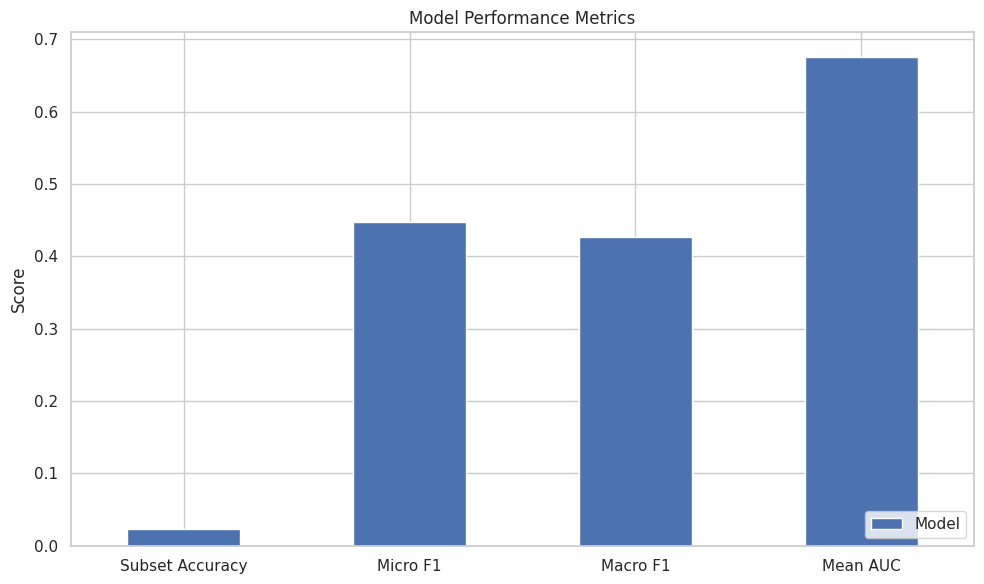

In [16]:
# Plot metrics
metrics_to_plot = ['Subset Accuracy', 'Micro F1', 'Macro F1', 'Mean AUC']
ax = summary_df[metrics_to_plot].T.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 5. Class-wise Performance

Let's look at the F1 score and AUC for each individual class to see which classes are harder to predict.

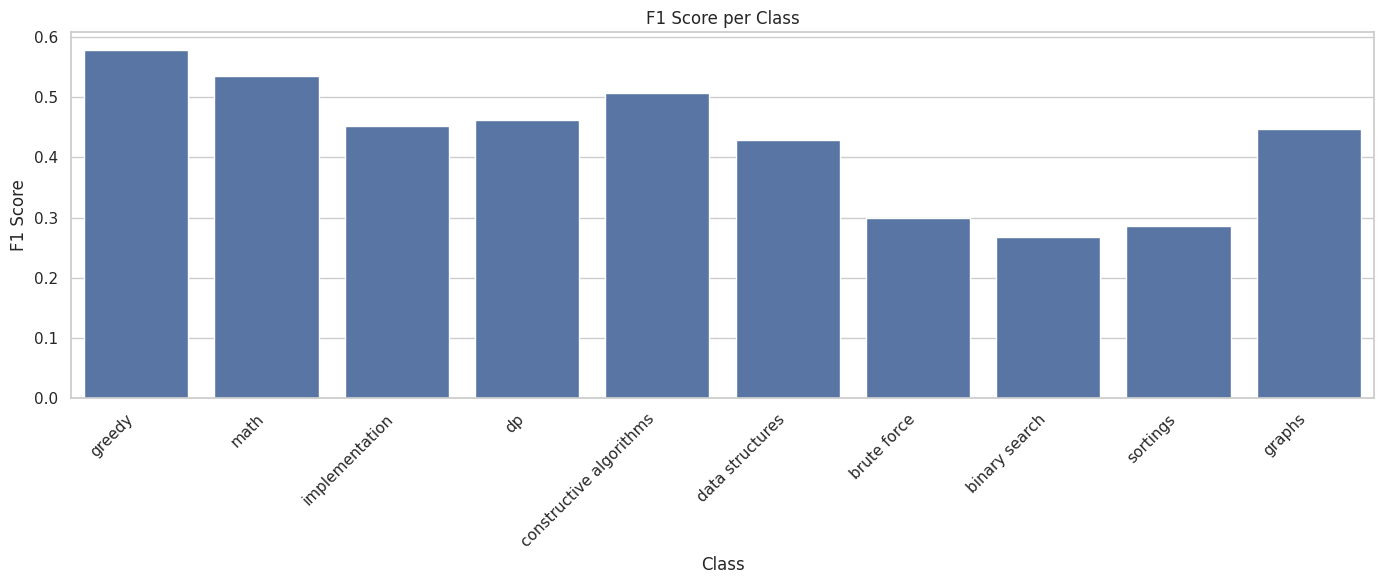

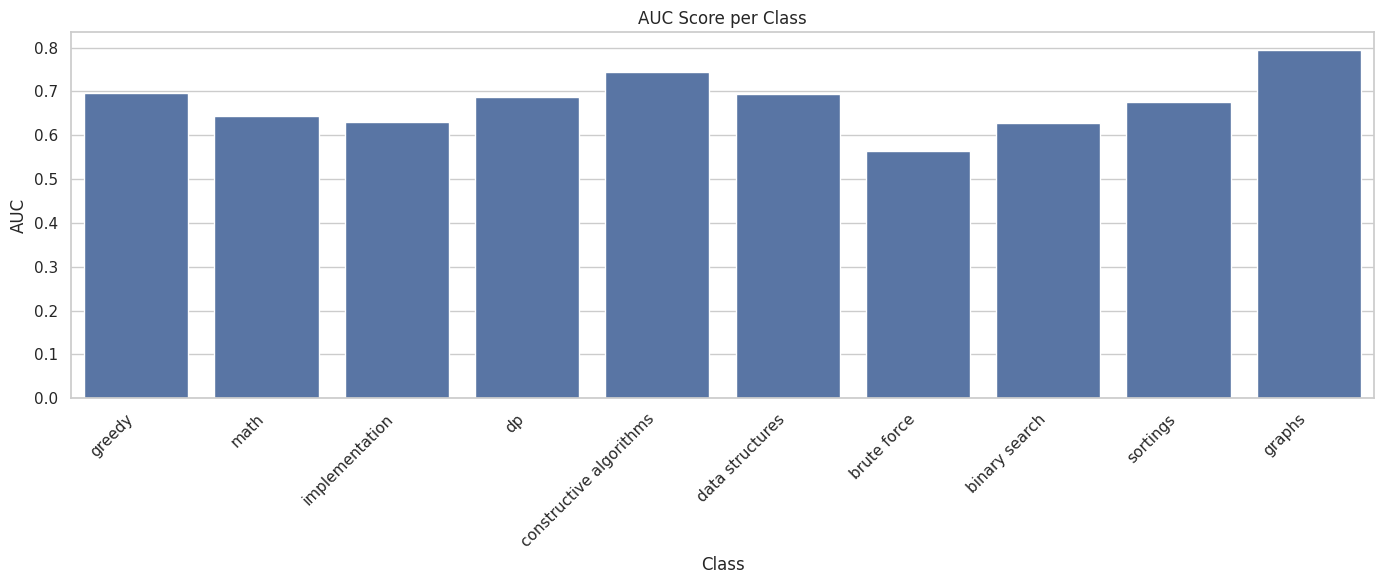


Class-wise Performance:


,Class,Label,F1 Score,AUC
0,0,greedy,0.578662,0.695172
1,1,math,0.535777,0.644532
2,2,implementation,0.452830,0.630759
3,3,dp,0.462745,0.687518
4,6,constructive algorithms,0.506912,0.744212
5,4,data structures,0.429553,0.693589
6,5,brute force,0.299113,0.564867
7,7,binary search,0.267516,0.628430
8,8,sortings,0.286245,0.675127
9,9,graphs,0.447592,0.794911


In [9]:
def get_class_f1(df):
    y_true = df[actual_cols].values
    y_pred = df[pred_cols].values
    return f1_score(y_true, y_pred, average=None)

def get_class_auc(df):
    y_true = df[actual_cols].values
    y_probs = df[prob_cols].values
    auc_scores = []
    for i in range(10):
        try:
            auc = roc_auc_score(y_true[:, i], y_probs[:, i])
            auc_scores.append(auc)
        except ValueError:
            auc_scores.append(np.nan)
    return auc_scores

f1_scores = get_class_f1(df)
auc_scores = get_class_auc(df)

# Create DataFrame with classes in the specified order
class_perf_df = pd.DataFrame({
    'Class': class_order,
    'Label': [class_labels[i] for i in class_order],
    'F1 Score': [f1_scores[i] for i in class_order],
    'AUC': [auc_scores[i] for i in class_order]
})

# Plot F1 scores
plt.figure(figsize=(14, 6))
sns.barplot(data=class_perf_df, x='Class', y='F1 Score', order=class_order)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.xlabel('Class')
plt.xticks(range(10), [class_labels[i] for i in class_order], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot AUC scores
plt.figure(figsize=(14, 6))
sns.barplot(data=class_perf_df, x='Class', y='AUC', order=class_order)
plt.title('AUC Score per Class')
plt.ylabel('AUC')
plt.xlabel('Class')
plt.xticks(range(10), [class_labels[i] for i in class_order], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display table
print("\nClass-wise Performance:")
display(class_perf_df[['Class', 'Label', 'F1 Score', 'AUC']])

## 6. Precision-Recall Curves

Precision-Recall curves show the trade-off between precision and recall for different probability thresholds. This is particularly useful for imbalanced datasets.


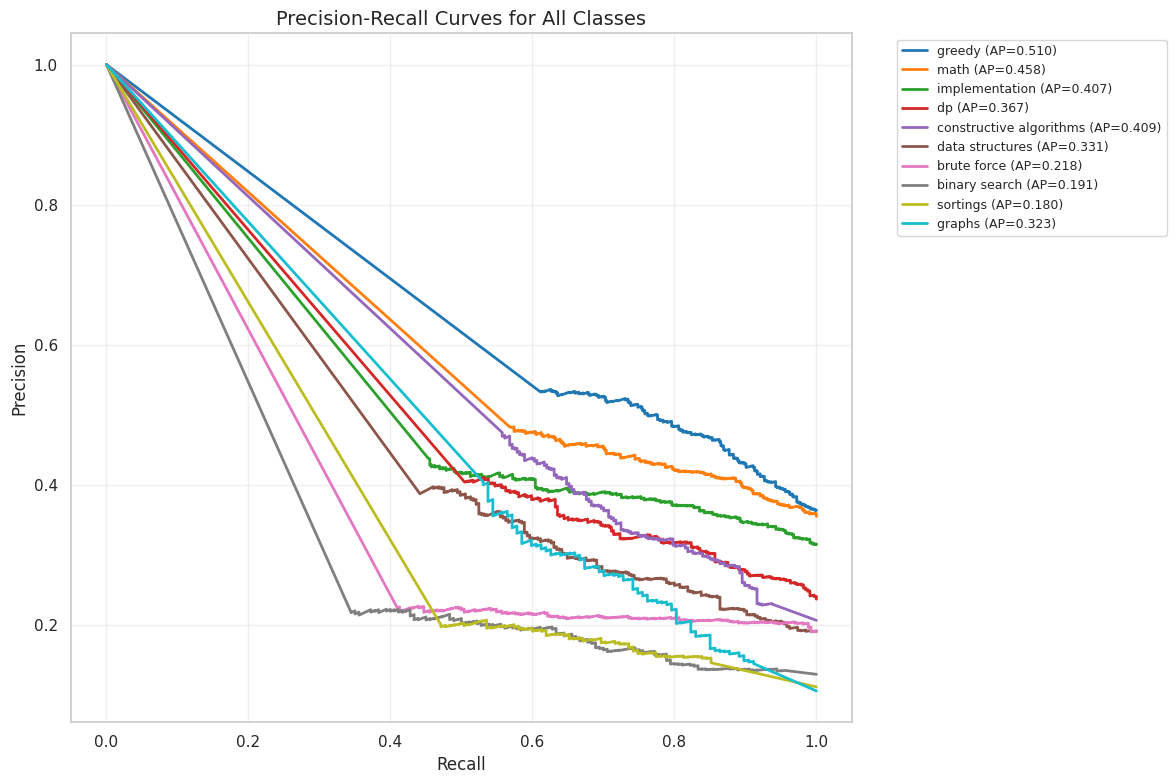


Average Precision (AP) Scores:
greedy                    (0): 0.5099
math                      (1): 0.4582
implementation            (2): 0.4065
dp                        (3): 0.3668
constructive algorithms   (6): 0.4090
data structures           (4): 0.3314
brute force               (5): 0.2177
binary search             (7): 0.1907
sortings                  (8): 0.1798
graphs                    (9): 0.3229
Mean Average Precision (mAP): 0.3393

Average Precision by Class:


,Class,Label,Average Precision
0,0,greedy,0.509950
1,1,math,0.458230
2,2,implementation,0.406531
3,3,dp,0.366754
4,6,constructive algorithms,0.408952
5,4,data structures,0.331390
6,5,brute force,0.217714
7,7,binary search,0.190745
8,8,sortings,0.179781
9,9,graphs,0.322870


In [7]:
# Calculate precision-recall curves for each class
y_true = df[actual_cols].values
y_probs = df[prob_cols].values

# Store precision, recall, and AP scores for each class
pr_curves = {}
ap_scores = {}

for i in class_order:
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
    ap = average_precision_score(y_true[:, i], y_probs[:, i])
    
    pr_curves[i] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds
    }
    ap_scores[i] = ap

# Plot all precision-recall curves
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for idx, i in enumerate(class_order):
    plt.plot(pr_curves[i]['recall'], pr_curves[i]['precision'], 
             label=f"{class_labels[i]} (AP={ap_scores[i]:.3f})", 
             color=colors[idx], linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves for All Classes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print Average Precision scores
print("\nAverage Precision (AP) Scores:")
print("=" * 60)
for i in class_order:
    print(f"{class_labels[i]:25s} ({i}): {ap_scores[i]:.4f}")
print("=" * 60)
print(f"Mean Average Precision (mAP): {np.mean(list(ap_scores.values())):.4f}")

# Create a DataFrame with AP scores
ap_df = pd.DataFrame({
    'Class': class_order,
    'Label': [class_labels[i] for i in class_order],
    'Average Precision': [ap_scores[i] for i in class_order]
})

print("\nAverage Precision by Class:")
display(ap_df)


## 7. Error Analysis

Let's inspect some examples where the model made incorrect predictions.

In [18]:
# Calculate exact matches for each row
df['exact_match'] = (df[pred_cols].values == df[actual_cols].values).all(axis=1)

correct = df[df['exact_match']]
incorrect = df[~df['exact_match']]

print(f"Number of samples with exact match: {len(correct)} ({len(correct)/len(df)*100:.2f}%)")
print(f"Number of samples with incorrect predictions: {len(incorrect)} ({len(incorrect)/len(df)*100:.2f}%)")

if not incorrect.empty:
    print("\nExample of incorrect prediction:")
    idx = incorrect.index[0]
    print("Problem Statement:", df.loc[idx, 'problem_statement'][:300] + "...")
    
    # Get actual and predicted classes
    actual = [i for i in range(10) if df.loc[idx, f'actual_class_{i}'] == 1]
    predicted = [i for i in range(10) if df.loc[idx, f'predicted_class_{i}'] == 1]
    
    print(f"\nActual classes: {[class_labels[i] for i in actual]} (indices: {actual})")
    print(f"Predicted classes: {[class_labels[i] for i in predicted]} (indices: {predicted})")
    
    # Show probabilities for predicted classes
    print(f"\nProbabilities for predicted classes:")
    for i in predicted:
        print(f"  {class_labels[i]} ({i}): {df.loc[idx, f'prob_class_{i}']:.4f}")
    
    # Show probabilities for actual classes
    print(f"\nProbabilities for actual classes:")
    for i in actual:
        print(f"  {class_labels[i]} ({i}): {df.loc[idx, f'prob_class_{i}']:.4f}")

Number of samples with exact match: 32 (2.30%)
Number of samples with incorrect predictions: 1357 (97.70%)

Example of incorrect prediction:
Problem Statement: You are given an integer n Check if n has an divisor greater than one does there exist such a number x x 1 that n is divisible by x and x is odd For example if n 6 then there is x 3 If n 4 then such a number does not exist ...

Actual classes: ['math'] (indices: [1])
Predicted classes: ['math', 'implementation', 'brute force'] (indices: [1, 2, 5])

Probabilities for predicted classes:
  math (1): 1.0000
  implementation (2): 1.0000
  brute force (5): 1.0000

Probabilities for actual classes:
  math (1): 1.0000


/tmp/ipykernel_295272/1312659768.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', n_classes)


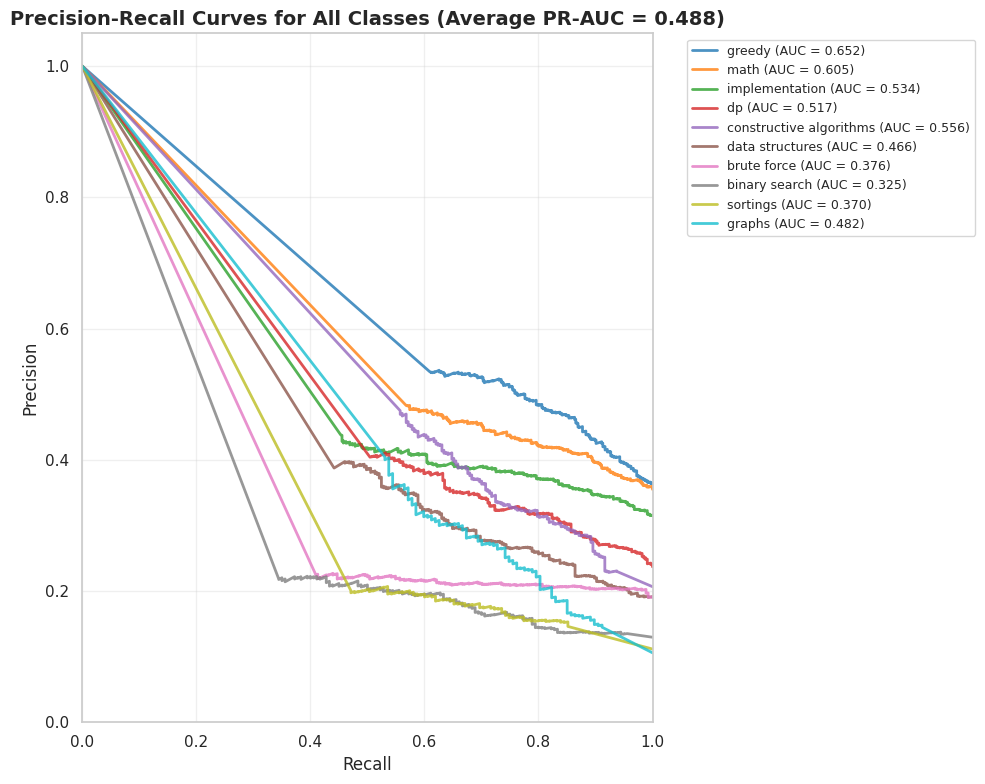


Precision-Recall AUC Summary:
Tag                       PR-AUC      
greedy                    0.6520      
math                      0.6050      
implementation            0.5336      
dp                        0.5169      
constructive algorithms   0.5559      
data structures           0.4663      
brute force               0.3759      
binary search             0.3251      
sortings                  0.3703      
graphs                    0.4823      
Average                   0.4883      
Std Dev                   0.1008      


[0.6519988576962378,
 0.6049756028648413,
 0.5336251360401362,
 0.5169090971276668,
 0.5558825987015876,
 0.4663018149620823,
 0.37585693147312094,
 0.32506327301199334,
 0.37030802121822143,
 0.48231923390754383]

In [8]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_all_pr_curves_combined():
    """
    Plot all precision-recall curves for all classes in a single plot with different colors.
    Shows the average PR-AUC in the title.
    """
    # Use class_order to maintain consistent ordering
    tag_names = [class_labels[i] for i in class_order]
    n_classes = len(tag_names)
    
    # Create a single figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Store AUC values for summary
    auc_scores = []
    
    # Generate a colormap for different colors
    colors = cm.get_cmap('tab10', n_classes)
    
    # Plot precision-recall curve for each tag
    for idx, class_idx in enumerate(class_order):
        tag_name = class_labels[class_idx]
        
        # Get actual labels (ground truth)
        y_true = df[f'actual_class_{class_idx}'].values
        
        # Get predicted probabilities
        y_pred_proba = df[f'prob_class_{class_idx}'].values
        
        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
        
        # Calculate AUC (Area Under Curve)
        pr_auc = auc(recall, precision)
        auc_scores.append(pr_auc)
        
        # Plot the curve with a unique color
        ax.plot(recall, precision, linewidth=2, label=f'{tag_name} (AUC = {pr_auc:.3f})', 
                color=colors(idx), alpha=0.8)
    
    # Calculate average PR-AUC
    avg_auc = np.mean(auc_scores)
    
    # Set labels and title
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'Precision-Recall Curves for All Classes (Average PR-AUC = {avg_auc:.3f})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.grid(alpha=0.3)
    
    # Add legend (place it outside the plot area)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrecision-Recall AUC Summary:")
    print("=" * 60)
    print(f"{'Tag':<25} {'PR-AUC':<12}")
    print("=" * 60)
    for idx, class_idx in enumerate(class_order):
        tag_name = class_labels[class_idx]
        print(f"{tag_name:<25} {auc_scores[idx]:<12.4f}")
    print("=" * 60)
    print(f"{'Average':<25} {avg_auc:<12.4f}")
    print(f"{'Std Dev':<25} {np.std(auc_scores):<12.4f}")
    print("=" * 60)
    
    return auc_scores

# Call the function to plot all PR curves in one plot
plot_all_pr_curves_combined()
